In [1]:
import pyspark
import os

In [2]:
myConf = pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
.builder\
.master('local')\
.appName('myApp')\
.config(conf=myConf)\
.getOrCreate()

21/10/18 07:29:51 WARN Utils: Your hostname, Kritiasui-MacBookAir.local resolves to a loopback address: 127.0.0.1; using 172.30.1.51 instead (on interface en0)
21/10/18 07:29:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/10/18 07:29:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# 데이터 준비

In [3]:
import requests
import json
from pyspark.sql import Row
r = requests.get('https://raw.githubusercontent.com/jokecamp/FootballData/master/World%20Cups/all-world-cup-players.json')
wc = r.json()
wcDf = spark.createDataFrame(Row(**x) for x in wc)

# Spark SQL

In [4]:
wcDf.printSchema()

root
 |-- Competition: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Team: string (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)



In [5]:
# 임시테이블 뷰 wc를 만들고 SQL문으로 데이터 조회
wcDf.createOrReplaceTempView('wc')
spark.sql('select Club,Team,Year from wc').show(1)

+--------------------+---------+----+
|                Club|     Team|Year|
+--------------------+---------+----+
|Club AtlÃ©tico Ta...|Argentina|1930|
+--------------------+---------+----+
only showing top 1 row



In [6]:
# for문으로 출력하기 위해 변수에 할당시킨다.
wcPlayers = spark.sql('select FullName,Club,Team,Year from wc')
wcPlayers.show(1)
type(wcPlayers)

+------------+--------------------+---------+----+
|    FullName|                Club|     Team|Year|
+------------+--------------------+---------+----+
|Ãngel Bossio|Club AtlÃ©tico Ta...|Argentina|1930|
+------------+--------------------+---------+----+
only showing top 1 row



pyspark.sql.dataframe.DataFrame

In [7]:
# 현재까지 만들어둔 테이블 목록 가져오기
spark.catalog.listTables()

[Table(name='wc', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [8]:
namesRdd = wcPlayers.rdd.map(lambda x : 'Full name: ' + x[0])
for e in namesRdd.take(5):
    print(e)
type(namesRdd)

Full name: Ãngel Bossio
Full name: Juan Botasso
Full name: Roberto Cherro
Full name: Alberto Chividini
Full name: 


pyspark.rdd.PipelinedRDD

In [9]:
bucketDf = spark.createDataFrame([[1, ['orange', 'apple', 'pineapple']], \
                                  [2, ['watermelon', 'apple', 'bananas']]], \
                                 ['bucketId', 'items'])
bucketDf.show(truncate = False)

+--------+----------------------------+
|bucketId|items                       |
+--------+----------------------------+
|1       |[orange, apple, pineapple]  |
|2       |[watermelon, apple, bananas]|
+--------+----------------------------+



In [10]:
# explode : 컬럼에 list나 array가 포함된 경우, flat해서 새로운 컬럼을 생성한다.
from pyspark.sql.functions import explode
bDf = bucketDf.select(bucketDf.bucketId, explode(bucketDf.items).alias('item'))
bDf.show()

+--------+----------+
|bucketId|      item|
+--------+----------+
|       1|    orange|
|       1|     apple|
|       1| pineapple|
|       2|watermelon|
|       2|     apple|
|       2|   bananas|
+--------+----------+



In [11]:
fDf = spark.createDataFrame([['orange', 'F1'],\
                            ['', 'F2'],\
                            ['pineapple', 'F3'],\
                            ['watermelon', 'F4'],\
                            ['bananas', 'F5'],],
                           ['item', 'itemId'])

In [12]:
fDf.show()

+----------+------+
|      item|itemId|
+----------+------+
|    orange|    F1|
|          |    F2|
| pineapple|    F3|
|watermelon|    F4|
|   bananas|    F5|
+----------+------+



## Join
- inner, cross, outer, full, full_outer, left, left_outer, right, right_outer, left_semi, left_anti..

In [13]:
joinDf = fDf.join(bDf, fDf.item == bDf.item, 'inner')

In [14]:
joinDf.select(fDf.itemId, fDf.item, bDf.bucketId).show()

+------+----------+--------+
|itemId|      item|bucketId|
+------+----------+--------+
|    F5|   bananas|       2|
|    F1|    orange|       1|
|    F3| pineapple|       1|
|    F4|watermelon|       2|
+------+----------+--------+



# 네트워크에 불법적으로 침입하는 사용자의 분석

In [15]:
_url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'
_fname = os.path.join(os.getcwd(), 'data', 'kddcup.data_10_percent.gz')

In [17]:
import os
import urllib

if(not os.path.exists(_fname)):
    print('{} data does not exist! retrieving..'.format(_fname))
    _f = urllib.request.urlretrieve(_url, _fname)

/Users/elplaguister/Workspace/Univ_BigDataAnalysis/Week7/data/kddcup.data_10_percent.gz data does not exist! retrieving..


1. 파일 -> RDD : 가능
2. 파일 -> DF : 불가능
3. 파일 -> RDD -> DF : 가능

In [18]:
_rdd = spark.sparkContext.textFile(_fname)
_rdd.count()

494021

In [19]:
_rdd.take(1)

['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.']

In [20]:
_allRdd = _rdd.map(lambda x : x.split(','))

In [21]:
_allRdd.take(1)

[['0',
  'tcp',
  'http',
  'SF',
  '181',
  '5450',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '8',
  '8',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '1.00',
  '0.00',
  '0.00',
  '9',
  '9',
  '1.00',
  '0.00',
  '0.11',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  'normal.']]

In [23]:
# 정상, 공격 건수
# 정상이면 normal, 공격이면 attack
_normalRdd = _allRdd.filter(lambda x: x[41] == 'normal.')
_attackRdd = _allRdd.filter(lambda x: x[41] != 'normal.')

In [24]:
_normalRdd.count(), _attackRdd.count()

(97278, 396743)

# attack별 건수
- DOS, R2L, U2R, probing

In [25]:
# reduceByKey 이용
_41 = _allRdd.map(lambda x: (x[41], 1))
_41.reduceByKey(lambda x,y: x+y).collect()

[('normal.', 97278),
 ('buffer_overflow.', 30),
 ('loadmodule.', 9),
 ('perl.', 3),
 ('neptune.', 107201),
 ('smurf.', 280790),
 ('guess_passwd.', 53),
 ('pod.', 264),
 ('teardrop.', 979),
 ('portsweep.', 1040),
 ('ipsweep.', 1247),
 ('land.', 21),
 ('ftp_write.', 8),
 ('back.', 2203),
 ('imap.', 12),
 ('satan.', 1589),
 ('phf.', 4),
 ('nmap.', 231),
 ('multihop.', 7),
 ('warezmaster.', 20),
 ('warezclient.', 1020),
 ('spy.', 2),
 ('rootkit.', 10)]

In [27]:
# groupByKey.mapValues 이용
def f(x): return len(x)
_41.groupByKey().mapValues(f).collect()

[('normal.', 97278),
 ('buffer_overflow.', 30),
 ('loadmodule.', 9),
 ('perl.', 3),
 ('neptune.', 107201),
 ('smurf.', 280790),
 ('guess_passwd.', 53),
 ('pod.', 264),
 ('teardrop.', 979),
 ('portsweep.', 1040),
 ('ipsweep.', 1247),
 ('land.', 21),
 ('ftp_write.', 8),
 ('back.', 2203),
 ('imap.', 12),
 ('satan.', 1589),
 ('phf.', 4),
 ('nmap.', 231),
 ('multihop.', 7),
 ('warezmaster.', 20),
 ('warezclient.', 1020),
 ('spy.', 2),
 ('rootkit.', 10)]

# Dataframe 생성

In [29]:
from pyspark.sql import Row

_csv = _rdd.map(lambda l: l.split(','))
_csvRdd = _csv.map(lambda p:
                  Row(
                  duration = int(p[0]),
                  protocol = p[1],
                  service = p[2],
                  flag = p[3],
                  src_bytes = int(p[4]),
                  dst_bytes = int(p[5]),
                  attack = p[41]
                  )
                  )

In [30]:
_df = spark.createDataFrame(_csvRdd)
_df.printSchema()
_df.show(5)

root
 |-- duration: long (nullable = true)
 |-- protocol: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- attack: string (nullable = true)

+--------+--------+-------+----+---------+---------+-------+
|duration|protocol|service|flag|src_bytes|dst_bytes| attack|
+--------+--------+-------+----+---------+---------+-------+
|       0|     tcp|   http|  SF|      181|     5450|normal.|
|       0|     tcp|   http|  SF|      239|      486|normal.|
|       0|     tcp|   http|  SF|      235|     1337|normal.|
|       0|     tcp|   http|  SF|      219|     1337|normal.|
|       0|     tcp|   http|  SF|      217|     2032|normal.|
+--------+--------+-------+----+---------+---------+-------+
only showing top 5 rows



# Attack Classification

In [33]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *
attack_udf = udf(lambda x: 'normal' if x == 'normal.' else 'attack', StringType())
myDf = _df.withColumn('attackB', attack_udf(_df.attack))

In [34]:
myDf.printSchema()

root
 |-- duration: long (nullable = true)
 |-- protocol: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- attack: string (nullable = true)
 |-- attackB: string (nullable = true)



In [35]:
def classify41(s):
    _5=""
    if s=="normal.":
        _5="normal"
    elif s=="back." or s=="land." or s=="neptune." or s=="pod." or s=="smurf." or s=="teardrop.":
        _5="dos"
    elif s=="ftp_write." or s=="guess_passwd." or s=="imap." or s=="multihop." or s=="phf." or\
        s=="spy." or s=="warezclient." or s=="warezmaster.":
        _5="r2l"
    elif s=="buffer_overflow." or s=="loadmodule." or s=="perl." or s=="rootkit.":
        _5="u2r"
    elif s=="ipsweep." or s=="nmap." or s=="portsweep." or s=="satan.":
        _5="probing"
    return _5

attack5_udf = udf(classify41, StringType())

In [37]:
myDf = myDf.withColumn('attack5', attack5_udf(_df.attack))
myDf.printSchema()
myDf.take(1)

root
 |-- duration: long (nullable = true)
 |-- protocol: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- attack: string (nullable = true)
 |-- attackB: string (nullable = true)
 |-- attack5: string (nullable = true)



[Row(duration=0, protocol='tcp', service='http', flag='SF', src_bytes=181, dst_bytes=5450, attack='normal.', attackB='normal', attack5='normal')]

Traceback (most recent call last):
  File "/Users/elplaguister/opt/anaconda3/envs/Analysis/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/Users/elplaguister/opt/anaconda3/envs/Analysis/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/Users/elplaguister/opt/anaconda3/envs/Analysis/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Users/elplaguister/opt/anaconda3/envs/Analysis/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [38]:
myDf.groupBy('attack5').count().show()

+-------+------+
|attack5| count|
+-------+------+
|probing|  4107|
|    u2r|    52|
| normal| 97278|
|    r2l|  1126|
|    dos|391458|
+-------+------+



In [40]:
myDf.groupBy('protocol').count().show()

+--------+------+
|protocol| count|
+--------+------+
|     tcp|190065|
|     udp| 20354|
|    icmp|283602|
+--------+------+



In [41]:
myDf.groupBy('attackB', 'protocol').count().show()

+-------+--------+------+
|attackB|protocol| count|
+-------+--------+------+
| normal|     udp| 19177|
| normal|    icmp|  1288|
| normal|     tcp| 76813|
| attack|    icmp|282314|
| attack|     tcp|113252|
| attack|     udp|  1177|
+-------+--------+------+



In [43]:
#pivot
myDf.groupBy('attackB').pivot('protocol').count().show()

+-------+------+------+-----+
|attackB|  icmp|   tcp|  udp|
+-------+------+------+-----+
| normal|  1288| 76813|19177|
| attack|282314|113252| 1177|
+-------+------+------+-----+



In [44]:
myDf.groupBy('attack5').pivot('protocol').avg('src_bytes').show()

+-------+------------------+------------------+------------------+
|attack5|              icmp|               tcp|               udp|
+-------+------------------+------------------+------------------+
|probing|10.700793650793651| 261454.6003016591|25.235897435897435|
|    u2r|              null| 960.8979591836735|13.333333333333334|
| normal| 91.47049689440993|1439.3120305156679| 98.01220211711947|
|    r2l|              null|271972.57460035523|              null|
|    dos| 936.2672084368129| 1090.303422435458|              28.0|
+-------+------------------+------------------+------------------+



In [45]:
myDf.groupBy('attack5').avg('duration').show()

+-------+--------------------+
|attack5|       avg(duration)|
+-------+--------------------+
|probing|   485.0299488677867|
|    u2r|    80.9423076923077|
| normal|  216.65732231336992|
|    r2l|   559.7522202486679|
|    dos|7.254929008986916E-4|
+-------+--------------------+



In [48]:
from pyspark.sql import functions as F
myDf.groupBy('attackB').pivot('protocol').agg(F.max('dst_bytes')).show()

+-------+----+-------+---+
|attackB|icmp|    tcp|udp|
+-------+----+-------+---+
| normal|   0|5134218|516|
| attack|   0|5155468| 74|
+-------+----+-------+---+



In [50]:
myDf.select('protocol', 'duration', 'dst_bytes')\
.filter(_df.duration > 1000)\
.filter(_df.dst_bytes == 0)\
.groupBy('protocol')\
.count()\
.show()

+--------+-----+
|protocol|count|
+--------+-----+
|     tcp|  139|
+--------+-----+



# SQL

In [51]:
_df.registerTempTable('_tab')
tcp_interactions = spark.sql(
'''SELECT duration,dst_bytes FROM _tab WHERE protocol='tcp'AND duration > 1000 AND dst_bytes =0
''')

In [53]:
tcp_interactions.show(5)

+--------+---------+
|duration|dst_bytes|
+--------+---------+
|    5057|        0|
|    5059|        0|
|    5051|        0|
|    5056|        0|
|    5051|        0|
+--------+---------+
only showing top 5 rows



In [54]:
tcp_interactions_out = tcp_interactions.rdd\
.map(lambda p: 'Duration: {}, Dest. bytes: {}'.format(p.duration, p.dst_bytes))

In [55]:
for i, ti_out in enumerate(tcp_interactions_out.collect()):
    if(i % 10 == 0):
        print(ti_out)

Duration: 5057, Dest. bytes: 0
Duration: 5043, Dest. bytes: 0
Duration: 5046, Dest. bytes: 0
Duration: 5051, Dest. bytes: 0
Duration: 5057, Dest. bytes: 0
Duration: 5063, Dest. bytes: 0
Duration: 42448, Dest. bytes: 0
Duration: 40121, Dest. bytes: 0
Duration: 31709, Dest. bytes: 0
Duration: 30619, Dest. bytes: 0
Duration: 22616, Dest. bytes: 0
Duration: 21455, Dest. bytes: 0
Duration: 13998, Dest. bytes: 0
Duration: 12933, Dest. bytes: 0


# 통계
- 샘플링, 분포, 중심극한정리, 분산, zscore, outliers를 배운다.
- 그룹 간에 차이가 있는지 통계 추론을 배운다.
- 명목 변수에 대한 빈도 분석을 배운다.
- 변수 간 상관관계를 배운다.

## 샘플링

### 무작위 수

In [60]:
import random

random.seed(3)
print(random.random(), random.random())

0.23796462709189137 0.5442292252959519


In [62]:
import numpy as np
print(np.random.random((3, 2)))

[[0.08359891 0.63150376]
 [0.44748063 0.18520825]
 [0.90715448 0.43501525]]


In [63]:
# rand : 균등 분포
# randn : 표준 정규 분포
np.random.randn()

-1.942216383035862

np.random.random_sample, random.sample 모두 균등 분포에서 표본을 추출한다.

In [64]:
np.random.random_sample((3, 2))

array([[0.97237925, 0.63535377],
       [0.93690497, 0.39525728],
       [0.85391854, 0.26958584]])

In [65]:
random.sample([1,2,3,4,6], 2)

[3, 4]

In [74]:
dice = []
for i in range(1000000):
    dice.append(random.randrange(1, 7))

In [75]:
print(dice[:10])

[2, 5, 3, 2, 6, 1, 6, 1, 2, 4]


## 히스토그램

In [76]:
for i in range(1, 7):
    print('Dice {}: {}회'.format(i, dice.count(i)))

Dice 1: 166460회
Dice 2: 166807회
Dice 3: 166450회
Dice 4: 167198회
Dice 5: 166715회
Dice 6: 166370회


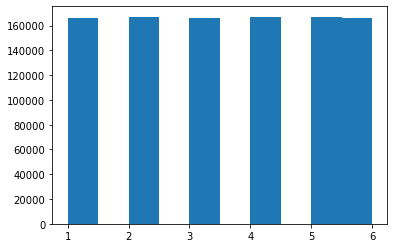

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(dice)
plt.show()

In [78]:
np.arange(0.5, 7, 1)

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])

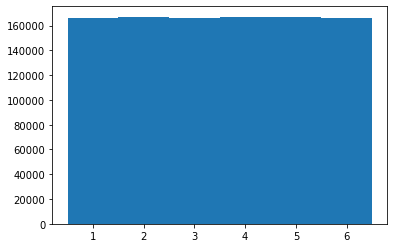

In [79]:
plt.hist(dice, bins = np.arange(0.5, 7))
plt.show()

<AxesSubplot:>

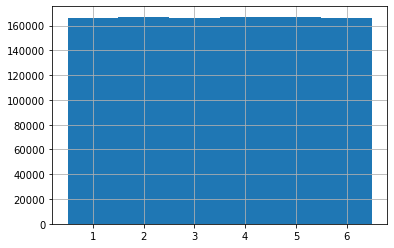

In [80]:
import pandas as pd
pd.Series(dice).hist(bins = np.arange(0.5 , 7))

## describe
- 기술 통계량

In [81]:
s = pd.Series(dice)

In [82]:
print(s.describe())

count    1000000.000000
mean           3.500011
std            1.707052
min            1.000000
25%            2.000000
50%            4.000000
75%            5.000000
max            6.000000
dtype: float64


# 정규분포

In [83]:
import numpy as np
comp1 = np.random.normal(0, 1, size = 200)

In [84]:
comp1[:5]

array([ 1.20601182, -0.43279131, -0.25373855,  0.93872346, -0.19920446])

In [85]:
x = np.random.randn(100)

In [87]:
count, binends = np.histogram(x)
print(count)
print(binends)

[ 2  0  7 12 15 18 23 11  7  5]
[-3.07662163 -2.52627432 -1.97592701 -1.4255797  -0.87523239 -0.32488508
  0.22546222  0.77580953  1.32615684  1.87650415  2.42685146]


(array([ 2.,  0.,  7., 12., 15., 18., 23., 11.,  7.,  5.]),
 array([-3.07662163, -2.52627432, -1.97592701, -1.4255797 , -0.87523239,
        -0.32488508,  0.22546222,  0.77580953,  1.32615684,  1.87650415,
         2.42685146]),
 <BarContainer object of 10 artists>)

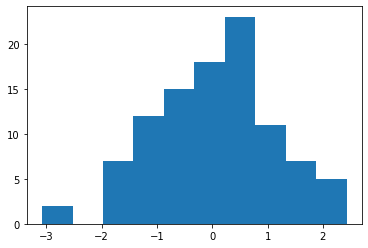

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(x)

<AxesSubplot:>

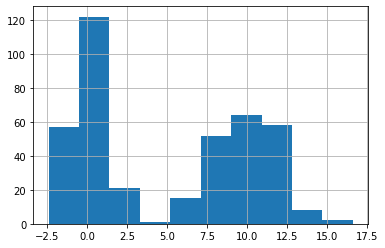

In [91]:
import pandas as pd
comp2 = np.random.normal(10, 2, size = 200)
values = pd.Series(np.concatenate([comp1, comp2]))
values.hist()

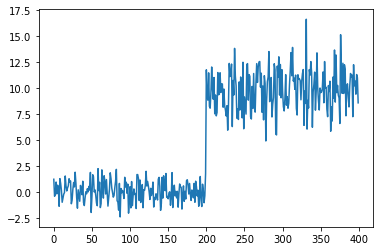

In [92]:
values.plot()
plt.show()

# 중심극한정리

In [96]:
x = np.random.randn(100)
print(np.mean(x),np.median(x))

0.050286064426013695 0.018287213362384445


In [97]:
# skewness : 0이면 정규분포 음수면 양의 방향으로 치우침
from scipy.stats import skew

print('skewness\t: ', skew(x))

skewness	:  -0.26857190161311456


In [98]:
# kurtosis : 양수일수록 뾰족함
from scipy.stats import kurtosis
print('kurtosis\t: ', kurtosis(x))

kurtosis	:  -0.20098946315575716


In [99]:
import pandas as pd
xPd = pd.DataFrame(x, columns = ['x'], dtype = float)
df = spark.createDataFrame(xPd)

In [100]:
from pyspark.sql import functions as f
df.select(f.skewness(df['x']), f.kurtosis(df['x'])).show()

+--------------------+--------------------+
|         skewness(x)|         kurtosis(x)|
+--------------------+--------------------+
|-0.26857190161311456|-0.20098946315575672|
+--------------------+--------------------+



## 분산

In [101]:
X = x


In [107]:
# 평균 수식 
print('simple mean of x = {:.3f}'.format(float(sum(X)/len(X))))

simple mean of x = 0.050


In [108]:
# 평균 라이브러리
xbar = np.mean(X)
#ybar = np.mean(Y)

In [105]:
print('simple mean of x = {:.3f}'.format(xbar))

simple mean of x = 0.050


In [109]:
# 분산 수식
print(np.sqrt(sum( [ (x - xbar) ** 2 for x in X] )/len(x)))

1.0798232362990245


In [111]:
# 표준편차
sx = np.sqrt(np.var(X, ddof = 1))

In [112]:
np.std(X, ddof = 1)

1.0852631862761035

In [118]:
a = np.arange(1, 6)
p = np.percentile(a, 50)
a, p

(array([1, 2, 3, 4, 5]), 3.0)

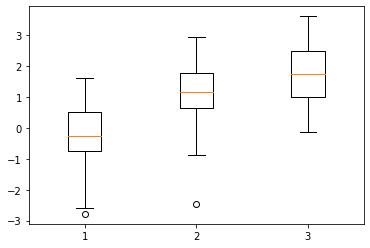

In [119]:
import matplotlib.pyplot as plt
x1 = np.random.normal(0, 1, 50) # mu sigma n
x2 = np.random.normal(1, 1, 50)
x3 = np.random.normal(2, 1, 50)
plt.boxplot([x1, x2, x3])
plt.show()

## zscore : 평균에서 표준편차의 몇 배가 떨어져 있는지


In [124]:
X = [10, 7, 12, 12, 9, 16, 12, 18, 8, 12, 14, 16]

xbar = np.mean(X)
sigmax = np.std(X)
sx = np.std(X, ddof = 1)
for x in X:
    zscore = (x - xbar) / sigmax
    print(zscore, end = ' ')

-0.669534063411986 -1.5965812281362746 -0.05150262026246029 -0.05150262026246029 -0.9785497849867488 1.184560266036591 -0.05150262026246029 1.8025917091861168 -1.2875655065615117 -0.05150262026246029 0.5665288228870654 1.184560266036591 

In [122]:
from scipy import stats

In [123]:
stats.zscore(X)

array([-0.66953406, -1.59658123, -0.05150262, -0.05150262, -0.97854978,
        1.18456027, -0.05150262,  1.80259171, -1.28756551, -0.05150262,
        0.56652882,  1.18456027])

## cdf | Cumulative Distribition Function -> 누적 확률

In [125]:
from scipy.stats import norm

norm.cdf(0, loc = 0, scale = 1)

0.5

In [127]:
norm.cdf(1) - norm.cdf(-1)

0.6826894921370859

## n이 작을 땐 t분포

In [130]:
from scipy.stats import t
t.cdf(1, 1) # dof 1

0.7500000000000002

In [131]:
t.cdf(1, 1, loc = 0, scale = 1)

0.7500000000000002

# outliers
- 이상값 체크

In [132]:
def reject_outliers(data):
    m = np.mean(data)
    s = np.std(data)
    filtered = [d for d in data if (m - 2 * s < d < m + 2 * s)]
    return filtered

In [134]:
d = [2, 4, 5, 1, 6, 5, 40]
filtered_d = reject_outliers(d)
print(filtered_d)

[2, 4, 5, 1, 6, 5]
